# Analysis of experimental results 

In [1]:
from pymongo import MongoClient
from bson.objectid import ObjectId
import matplotlib, math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import groupby
from operator import itemgetter
from tabulate import tabulate
import functools

### Connecting to local mongo database

In [2]:
host = 'localhost'
port = 27017
username = ''
password = ''
database = 'tcc-recsys-mongo'

client = MongoClient(host, port)
db = client[database]

### Looking at quantity of crawled products by category

In [3]:
movies = 0
games = 0
books = 0
musics = 0
for prod in db.produto_novo.find({"categorias":{"$exists":True}}):
    if prod['categorias'][1] == u'Filmes':
        movies = movies + 1
    elif prod['categorias'][1] == u'Games':
        games = games + 1
    elif prod['categorias'][1] == u'Livros':
        books = books + 1
    else:
        musics = musics + 1
print("The number of movies is {}.".format(movies))
print("The number of games is {}.".format(games))
print("The number of books is {}.".format(books))
print("The number of musics is {}.".format(musics))

The number of movies is 2637.
The number of games is 667.
The number of books is 9168.
The number of musics is 298.


### Taking the biggest similarity of the recommendations made

In [4]:
biggest_similarity = 0.0
for user in db.users.find({"avaliacoes":{"$exists":True}}):
    for avaliacao in user['avaliacoes']:
        if float(avaliacao['similaridade']) > biggest_similarity:
            biggest_similarity = float(avaliacao['similaridade'])
print(float(biggest_similarity))

0.7064693507478099


### Calculating the RMSE of the recommendations

In [5]:
num_avaliacoes_total = 0
soma_total = 0
recs = []
for user in db.users.find({"avaliacoes":{"$exists":True}}):
    maior_similaridade_usuario = 0
    for avaliacao in user['avaliacoes']:
        if float(avaliacao['similaridade']) > maior_similaridade_usuario:
            maior_similaridade_usuario = float(avaliacao['similaridade'])
            
    soma_usuario = 0
    for avaliacao in user['avaliacoes']:
        prod = db.produto_novo.find_one({'_id': ObjectId(avaliacao['idprod'])})
        nota_sistema = int(float(avaliacao['similaridade'])/float(maior_similaridade_usuario)*4) +1
        
        for recomendacao in user['recomendacoes']:
            for product_rec in recomendacao['products']:
                if product_rec['idprod'] == avaliacao['idprod']:
                    produto_recomendacao = product_rec['nome']
                    post_recomendacao =  recomendacao['post']
                    
        recs.append([float(avaliacao['similaridade']), prod['nome'], avaliacao['nota'], nota_sistema, produto_recomendacao, post_recomendacao])
        dif_2 = math.sqrt(pow((int(avaliacao['nota'])-nota_sistema), 2))
        soma_usuario = soma_usuario + dif_2
        
        num_avaliacoes_total = num_avaliacoes_total + 1
        
    soma_total = soma_total + soma_usuario
    
rmse = round(math.sqrt(float(1)/num_avaliacoes_total*soma_total), 3)
print("The RMSE is {}.".format(rmse))

The RMSE is 1.222.


### Similarity ranges

In [6]:
def reduce_value(obj1, obj2):
    return (obj1[0], obj1[1]+obj2[1])

sim_grouped = [functools.reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (round(x[0],2), 1), recs)), key=itemgetter(0))]

print("Quantity of recommendations by similarity range.")
print(tabulate(map(lambda x: (x[0], x[1], x[1]/float(len(recs))*100), sim_grouped)))

Quantity of recommendations by similarity range.
----  ---  ---------
0     496  85.3701
0.01   81  13.9415
0.02    2   0.344234
0.03    1   0.172117
0.07    1   0.172117
----  ---  ---------


In [7]:
def reduce_value(obj1, obj2):
    return (obj1[0], obj1[1]+obj2[1], obj1[2]+obj2[2])

dif_grouped = [functools.reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (abs(int(x[2])-int(x[3])), x[0], 1), recs)), key=itemgetter(0))]
not_usr_grouped = [functools.reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (x[2], x[0], 1), recs)), key=itemgetter(0))]
not_sys_grouped = [functools.reduce(reduce_value, group) for _, group in groupby(sorted(map(lambda x: (x[3], x[0], 1), recs)), key=itemgetter(0))]
print("Number of recommendations: {}.".format(len(recs)))
print("Quantity of recommendation by difference of system and user rates.")
print(tabulate(map(lambda x: (x[0], x[2], x[1]/x[2], float(x[2])/float(len(recs))*100), dif_grouped)))
print("Number of user rates by rate")
print(tabulate(map(lambda x: (x[0], x[2], x[1]/x[2], float(x[2])/float(len(recs))*100), not_usr_grouped)))
print("Number of system rates by rate")
print(tabulate(map(lambda x: (x[0], x[2], x[1]/x[2], float(x[2])/float(len(recs))*100), not_sys_grouped)))


Number of recommendations: 581.
Quantity of recommendation by difference of system and user rates.
-  ---  ----------  --------
0  101  0.00317949  17.3838
1  223  0.00237835  38.3821
2  159  0.00280383  27.3666
3   66  0.00335708  11.3597
4   32  0.00781338   5.50775
-  ---  ----------  --------
Number of user rates by rate
-  ---  ----------  --------
1  243  0.00334754  41.8244
2   57  0.00240073   9.81067
3  130  0.00257628  22.3752
4   63  0.00306005  10.8434
5   88  0.00330579  15.1463
-  ---  ----------  --------
Number of system rates by rate
-  ---  ----------  --------
1   57  0.00375235   9.81067
2  245  0.00215274  42.1687
3  168  0.00266411  28.9157
4   46  0.00368126   7.91738
5   65  0.0063183   11.1876
-  ---  ----------  --------


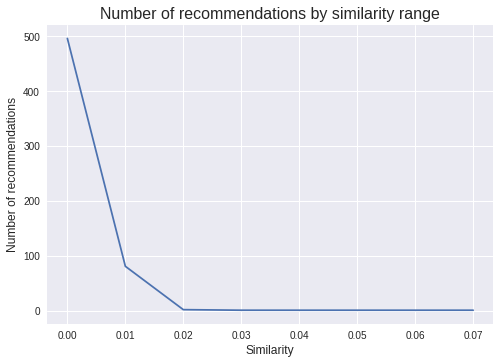

In [8]:
sns.set_style("darkgrid")
plt.plot(list(map(lambda x: x[0], sim_grouped)), list(map(lambda x: x[1], sim_grouped)))
plt.ylabel('Number of recommendations', fontsize=12)
plt.xlabel('Similarity', fontsize=12)
plt.title('Number of recommendations by similarity range', fontsize=16)
plt.show()

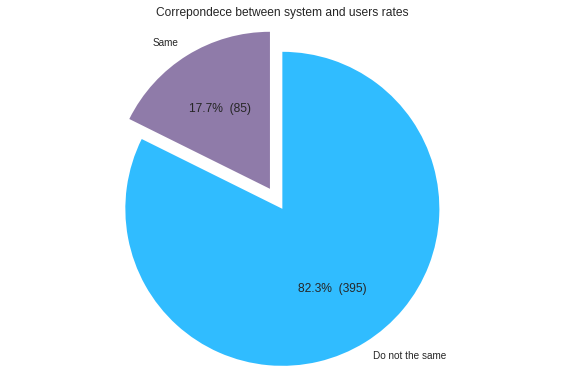

In [9]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
colors = ["#8f7ba9", "#30bcff"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    [103, 223+159+66+32],
    # with the labels being, officer names
    labels=["Same", "Do not the same"],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct=make_autopct([223+159+66+32]),
    )

# View the plot drop above
plt.axis('equal')
plt.title('Correpondece between system and users rates', fontsize=12)
# View the plot
plt.tight_layout()
plt.show()